# Research Question 1: Remixes vs Original Songs Popularity Ranks
## Subquestion: If the Deezer songs are paired, do original songs perform better than their most popular remix?
Deezer scores songs out of 1,000,000 to determine how popular a song is (called rank, we will just call is popularity score), in this notebook we will be comparing the popularity ranks of original songs to its highest ranked remix/alternate version.

Very hepful tutorial for RegEx on W3 Schools and article by Alexander Obregon that was used as a guide:
<https://www.w3schools.com/python/python_regex.asp> <br>
<https://medium.com/@AlexanderObregon/getting-started-with-regex-in-python-173972a40584>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [13]:
# Read in CSV file of top Spotify artists
df = pd.read_csv('../../Data/Processed/deezer_grouped.csv')
df.head()
df.shape

(402171, 12)

This code prepares and pairs original songs with their top remix/alternate versions for analysis:

1. Clean Column Names<br>
All column names are converted to lowercase for consistency

2. Extract Main Titles<br>
A helper function removes any text in brackets e.g. "(Remix)" or "\[Extended]" from song titles to generate a normalised `main_title`

3. Identify Original Versions<br>
Uses the `is_main_version` column to select original versions of songs, these are renamed for clarity (`original_title`, `original_rank`)

5. Select Top Remixes<br>
The top remix/alternate version per artist and base title is selected based on its popularity score, we know these songs are not the originals because of (is_main_version == False)

7. Pair Originals with Remixes<br>
Originals and remixes are merged based on main_title and artist to form pairs

In [16]:
# Standardise column names
df.columns = df.columns.str.lower()

# Helper function to extract base titles
def get_base_title(title):
    cleaned_title = re.sub(r'[\(\[].*?[\)\]]', '', title)  # Remove remix/alternate text
    return cleaned_title.strip().lower()

df['main_title'] = df['title'].apply(get_base_title)

# Copy the df of the original data set to separate original songs using 'is_main_version'
originals = df[df['is_main_version'] == True].copy()
originals = originals.rename(columns={'title': 'original_title', 'rank': 'original_rank'})

# Get the top remix/alternate version (most popular non-main version per artist and main_title)
alternates = (
    df[df['is_main_version'] == False]
    .sort_values('rank', ascending=False)
    .drop_duplicates(subset=['main_title', 'artist'], keep='first')
    .rename(columns={'title': 'remix_title', 'rank': 'remix_rank'})
)

# Merge original and remix into pairs
paired = pd.merge(
    originals[['main_title', 'artist', 'original_title', 'original_rank']],
    alternates[['main_title', 'artist', 'remix_title', 'remix_rank']],
    on=['main_title', 'artist']
)

# Save paired data
paired.to_csv('../../Data/Processed/paired_deezer_remixes.csv', index=False)

print(paired.shape)

(30063, 6)


The code below creates a layered histogram to directly compare the popularity scores of original songs vs remixes, it's scaled logarithmically to make the differences more obvious and zooms in on the chart for visibility.

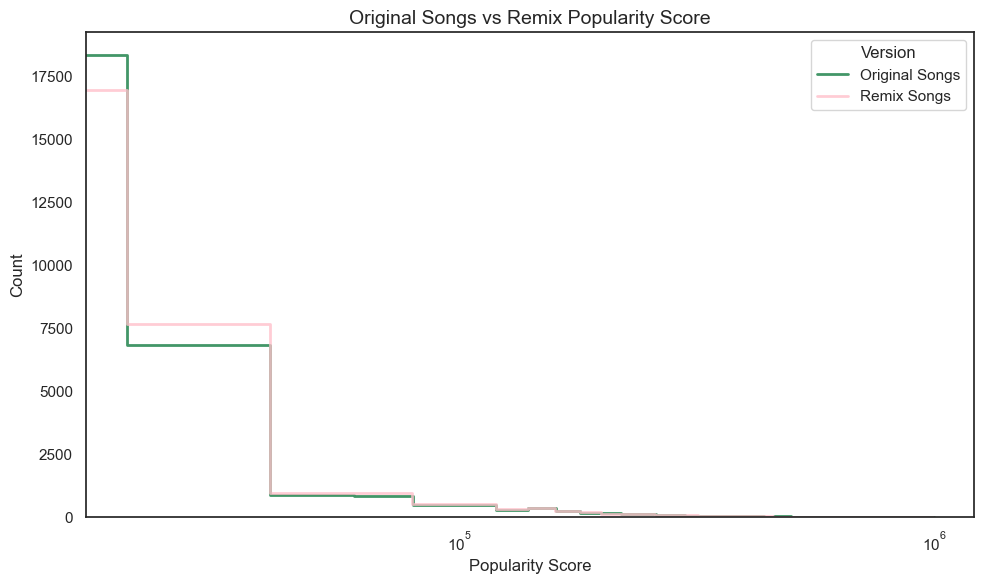

In [19]:
sns.set(style="white")
plt.figure(figsize=(10, 6))

# Layered histogram
sns.histplot(
    paired['original_rank'],
    color='seagreen',
    label='Original Songs',
    bins=50,
    kde=False,
    stat='count',
    element='step',
    alpha=0.9,
    fill=False,
    linewidth=2
)

sns.histplot(
    paired['remix_rank'],
    color='pink',
    label='Remix Songs',
    bins=50,
    kde=False,
    stat='count',
    element='step',
    alpha=0.8,
    fill=False,
    linewidth=2
)

# Add log scale
plt.xscale('log')

plt.title('Original Songs vs Remix Popularity Score', fontsize=14)
plt.xlabel('Popularity Score')
plt.ylabel('Count')
plt.legend(title='Version')

plt.tight_layout()
plt.savefig('s5_1_paired_deezer.png', dpi=300)
plt.show()

So what does this graph tell us? It shows us that there are more original songs that are very poorly ranked than remixes, we can also see that the difference between highly ranked originals and highly ranked remixes is very minuscule. However, the amount of remixes at high popularity scores is just slightly greater than original songs so we can conclude that remixes have tend to perform better than originals by a small amount.